In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [2]:
# Penerapan Metode Analytic Hierarchy Process

# Fungsi untuk menormalisasi matriks
def create_normalize_matrix(comparison_matrix):
    # Menghitung norma L1 (jumlah absolut dari setiap kolom)
    norm = np.sum(np.abs(comparison_matrix), axis=0)
    # Membagi setiap elemen dengan norma kolomnya untuk normalisasi
    normalized_matrix = comparison_matrix / norm
    return normalized_matrix

# Fungsi untuk menghitung bobot elemen
def calculated_weights(normalize_matrix):
    weights = normalize_matrix.sum(axis=1)/normalize_matrix.shape[0]
    return weights

# Fungsi untuk menghitung Consistency Ratio (CR)
def consistency_ratio(comparison_matrix, weights):
    # Mengalikan matriks A dengan vektor bobot W
    lambda_max_vector = np.dot(comparison_matrix, weights)
    # Menghitung nilai lambda_max
    lambda_max = np.sum(lambda_max_vector) #/ np.sum(weights)
    # Menghitung Consistency Index (CI)
    n = comparison_matrix.shape[0]
    CI = (lambda_max - n) / (n - 1)
    # Tabel Random Index (RI) untuk n = 1 hingga 15
    RI = [0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49, 1.51, 1.48, 1.56, 1.57, 1.59]
    if n <= 15 :
        random_index = RI[n] # Memilih RI berdasarkan jumlah kriteria, atau 1.59 jika n > 15
    else :
        random_index = 1.59
    # Menghitung Consistency Ratio (CR)
    CR = CI / random_index
    return CR

# Fungsi untuk membuat dan membulatkan matriks perbandingan dengan konsistensi
def create_and_round_consistent_matrix(data):
    n = len(data)  # Jumlah komponen
    matrix = np.ones((n, n))  # Membuat matriks n x n dengan nilai 1
    for i in range(n):
        for j in range(i+1, n):  # Hanya isi setengah atas matriks karena simetris
            # Perbandingan antar komponen dan pembulatan ke skala AHP terdekat
            comparison_value = data[i] / data[j]
            rounded_value = min(ahp_scale, key=lambda x: abs(x-comparison_value))
            matrix[i][j] = rounded_value
            matrix[j][i] = 1 / rounded_value  # Menggunakan nilai kebalikan untuk elemen simetris
    return matrix

# Fungsi untuk menghitung skor alternatif
def calculate_alternative_scores(alternative_matrix, weights):
    scores = np.dot(alternative_matrix, weights)
    return scores

In [3]:
# Membaca data kriteria dari file Excel
df_kriteria = pd.read_excel('E:/Skripsi/Data/NilaiKriteria.xlsx', sheet_name='Kriteria', usecols='A:K', nrows=11, header=None, index_col=False)
criteria_names = df_kriteria.iloc[1:, 0].tolist()
criteria_matrix = df_kriteria.iloc[1:, 1:].to_numpy(dtype=float)

# Membaca data alternatif dari file Excel
df_alternatif = pd.read_excel('E:/Skripsi/Data/NilaiKriteria.xlsx', sheet_name='Alternatif', usecols='A:K', nrows=26, header=None, index_col=False)
alternatif_names = df_alternatif.iloc[1:, 0].tolist()
alternatif_matrix = df_alternatif.iloc[1:, 1:].to_numpy(dtype=float)

In [4]:
# Matriks Perbandingan Kriteria
#print("Matriks Perbandingan Kriteria:")
#print(pd.DataFrame(criteria_matrix))
#print()

# Normalisasi matriks kriteria
normalize_criteria_matrix = create_normalize_matrix(criteria_matrix)
#print("Normalisasi Matriks Kriteria:")
#print(pd.DataFrame(normalize_criteria_matrix))
#print()

# Menghitung bobot kriteria
criteria_weights = calculated_weights(normalize_criteria_matrix)
#print("Bobot Kriteria:")
#print(pd.DataFrame(criteria_weights))
#print()

# Menghitung Consistency Ratio (CR) untuk kriteria
CR = consistency_ratio(criteria_matrix, criteria_weights)
print(f"CR = {CR}")

CR = 0.0046062687298659135


In [5]:
# Nilai skala perbandingan AHP
ahp_scale = [1/9, 1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Inisialisasi matriks bobot
weights_matrix = np.zeros((len(alternatif_matrix), len(alternatif_matrix[0])))

# Bobot alternatif pada tiap kriteria
for i in range(len(alternatif_matrix[0])):
    data = []
    for j in range(len(alternatif_matrix)):
        data.append(alternatif_matrix[j][i])
    # Menyesuaikan dengan skala nilai perbandingan AHP
    matrix = create_and_round_consistent_matrix(data)
    #rint(f"Matriks Perbandingan Alternatif pada {criteria_names[i]}:")
    #print(pd.DataFrame(matrix))
    #print()
    # Normailsasi matriks
    normalize_matrix = create_normalize_matrix(matrix)
    #print(f"Normalisasi Matriks Perbandingan Alternatif pada {criteria_names[i]}:")
    #print(pd.DataFrame(normalize_matrix))
    #print()
    # Menghitung bobot
    alternatif_weights = calculated_weights(normalize_matrix)
    #print(f"Bobot Alternatif pada {criteria_names[i]}:")
    #print(pd.DataFrame(alternatif_weights))
    #print()
    # Menghitung consistency ratio
    CR = consistency_ratio(matrix, alternatif_weights)
    #print(f"CR {criteria_names[i]} = {CR}")
    #print()
    #print("-"*70)
    #print()
    # Menyimpan bobot ke dalam matriks bobot
    weights_matrix[:, i] = alternatif_weights
    # Membuat dictionary untuk menyimpan nama dan skor alternatif
    alternatif_dict = {name: score for name, score in zip(alternatif_names, alternatif_weights)}
    # Mengurutkan alternatif berdasarkan skor
    sorted_alternatif = sorted(alternatif_dict.items(), key=lambda item: item[1], reverse=True)

In [6]:
# Menghitung score untuk tiap alternatif
alternatif_scores = calculate_alternative_scores(weights_matrix, criteria_weights)

# Membuat dictionary untuk menyimpan nama dan skor alternatif
alternatif_dict = {name: score for name, score in zip(alternatif_names, alternatif_scores)}

# Mengurutkan alternatif berdasarkan skor
sorted_alternatif = sorted(alternatif_dict.items(), key=lambda item: item[1], reverse=True)

# Menampilkan peringkat alternatif
print("Peringkat Alternatif:")
for rank, (name, score) in enumerate(sorted_alternatif, start=1):
    print(f"{rank}. {name} dengan skor: {score}")

Peringkat Alternatif:
1. INCO dengan skor: 0.049450974462928975
2. AUTO dengan skor: 0.04938931158846048
3. JSMR dengan skor: 0.04720473729399183
4. BBNI dengan skor: 0.046808599156783634
5. BMRI dengan skor: 0.04619022839909748
6. INDF dengan skor: 0.04605491778673364
7. DSNG dengan skor: 0.04464466724660891
8. AALI dengan skor: 0.04464367915349914
9. TLKM dengan skor: 0.04439510421607459
10. ANTM dengan skor: 0.04407547988771904
11. INTP dengan skor: 0.043887636619592205
12. BBTN dengan skor: 0.04299293790832036
13. BBRI dengan skor: 0.04220729476405556
14. KLBF dengan skor: 0.04180498822095813
15. SMGR dengan skor: 0.04176011225680144
16. DRMA dengan skor: 0.04028791794166454
17. EMTK dengan skor: 0.039806123960842196
18. JPFA dengan skor: 0.038492192255773355
19. SILO dengan skor: 0.033482567005420745
20. ICBP dengan skor: 0.03217792217128311
21. TINS dengan skor: 0.031678625606007975
22. BBCA dengan skor: 0.029602748446070543
23. SSMS dengan skor: 0.02868240432584209
24. UNVR deng

In [7]:
#Penerapan Metode Mean-Variance

# Fungsi untuk menghitung rasio Sharpe portofolio
def calculate_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    port_return = np.sum(mean_returns * weights) * 252
    port_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (port_return - risk_free_rate) / port_stddev
    return -sharpe_ratio # Negatif karena kita ingin memaksimalkan rasio Sharpe

# Fungsi untuk mendapatkan bobot aset optimal
def get_optimal_weights(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(calculate_sharpe_ratio, num_assets*[1./num_assets,], 
                      args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Fungsi untuk menetapkan nama ticker ke bobot yang dihasilkan
def assign_tickers_to_weights(tickers, optimal_weights):
    # Membuat dictionary untuk memetakan nama ticker ke bobot optimal mereka
    ticker_weights = {ticker: weight for ticker, weight in zip(tickers, optimal_weights)}
    return ticker_weights

In [8]:
# Mengambil top 5 saham berdasarkan AHP
top5_stock = [name + '.JK' for name, score in sorted_alternatif[:5]]

# Ambil data historis pengembalian saham
tickers = top5_stock
start_date = '2023-04-01'
end_date = '2024-03-31'
returns = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].pct_change()

[*********************100%%**********************]  5 of 5 completed


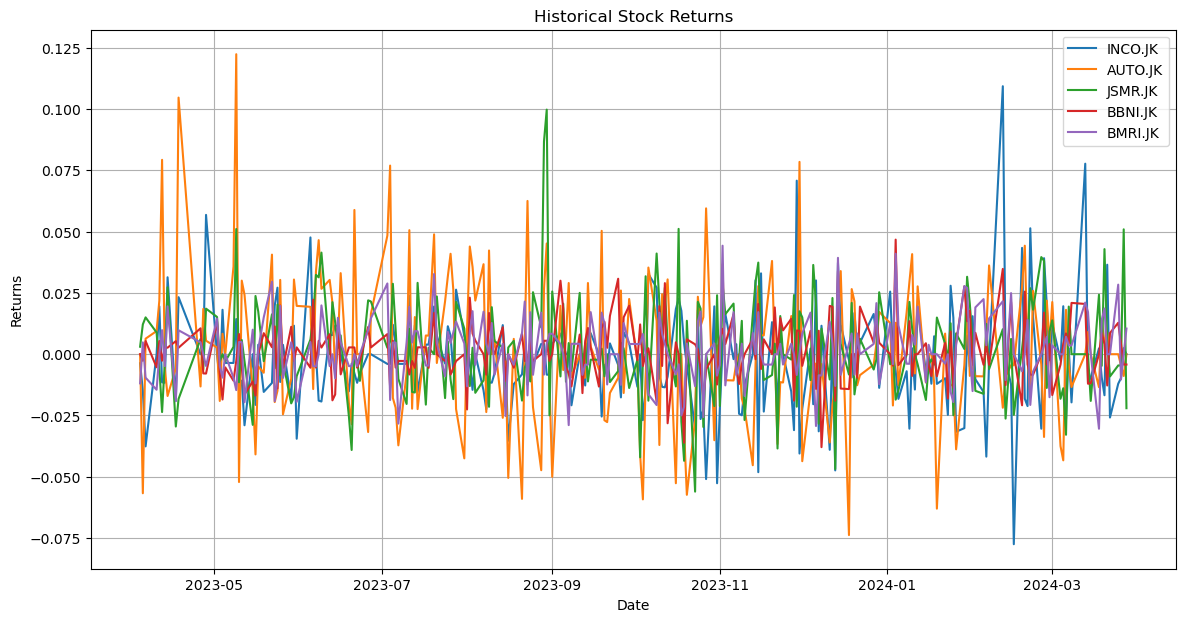

In [9]:
# Menampilkan data dalam bentuk diagram
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(returns.index, returns[ticker], label=ticker)

plt.title('Historical Stock Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  5 of 5 completed


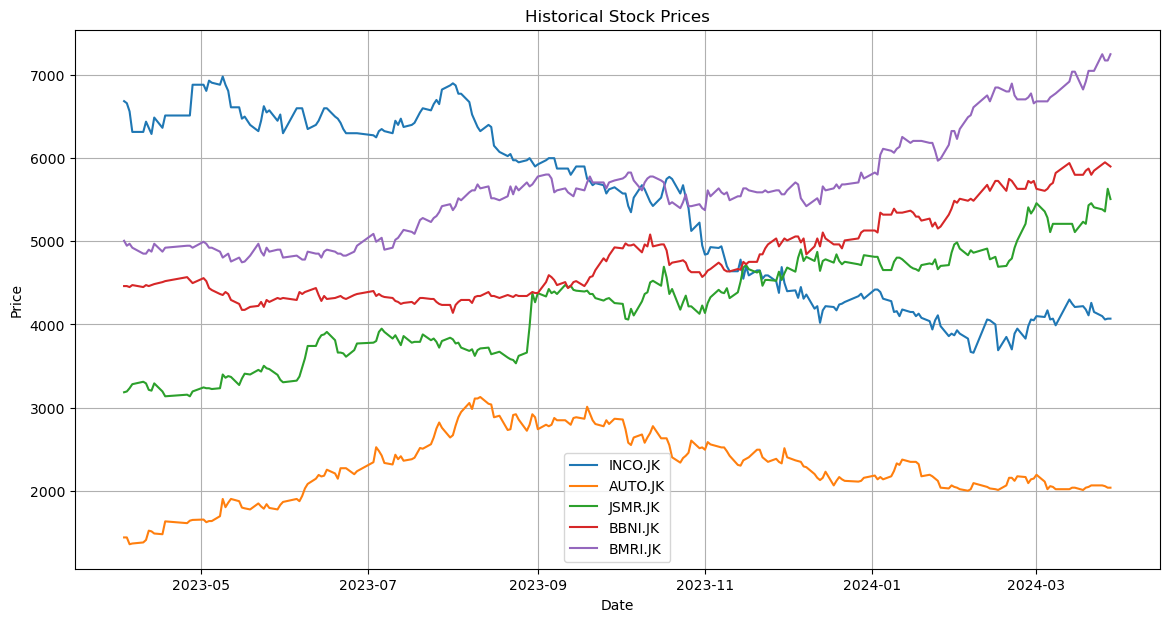

In [10]:
# Ambil data historis harga saham (hanya untuk pengecekan)
prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Menampilkan data dalam bentuk diagram
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(prices.index, prices[ticker], label=ticker)

plt.title('Historical Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Hitung rata-rata pengembalian dan matriks kovariansi
mean_returns = returns.mean()
print(f"Rata-rata Pengembalian: {mean_returns}")
cov_matrix = returns.cov()
print(pd.DataFrame(cov_matrix))

# Urutkan ticker berdasarkan mean_returns
tickers = mean_returns.sort_index().index.tolist()

# Simulasi portofolio
num_portfolios = 50000
results = np.zeros((4 , num_portfolios))
risk_free_rate = 0.05875 #BI-RATE

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    port_return = np.sum(mean_returns * weights) * 252
    port_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    port_sharpe = (port_return - risk_free_rate) / port_stddev
    results[0,i] = port_return
    results[1,i] = port_stddev
    results[2,i] = port_sharpe


# Data hasil simulasi
port_returns, port_vols, sharpe_ratios, port_weights = results

# Menghitung bobot aset optimal
optimal_weights = get_optimal_weights(mean_returns, cov_matrix, risk_free_rate)
print(optimal_weights)

# Menghitung rasio Sharpe portofolio optimal
optimal_sharpe = -calculate_sharpe_ratio(optimal_weights, mean_returns, cov_matrix, risk_free_rate)

# Menghitung pengembalian dan volatilitas portofolio optimal
optimal_return = np.sum(mean_returns * optimal_weights) * 252
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * np.sqrt(252)

Rata-rata Pengembalian: Ticker
AUTO.JK    0.001900
BBNI.JK    0.001267
BMRI.JK    0.001666
INCO.JK   -0.001891
JSMR.JK    0.002552
dtype: float64
Ticker    AUTO.JK   BBNI.JK   BMRI.JK   INCO.JK   JSMR.JK
Ticker                                                   
AUTO.JK  0.000837 -0.000003  0.000022  0.000012  0.000077
BBNI.JK -0.000003  0.000147  0.000071  0.000007  0.000019
BMRI.JK  0.000022  0.000071  0.000167  0.000002  0.000030
INCO.JK  0.000012  0.000007  0.000002  0.000462  0.000049
JSMR.JK  0.000077  0.000019  0.000030  0.000049  0.000424
[9.04324002e-02 2.27784906e-01 3.86340211e-01 1.40601031e-15
 2.95442482e-01]


Portofolio Optimal
Bobot untuk AUTO.JK: 9.043240%
Bobot untuk BBNI.JK: 22.778491%
Bobot untuk BMRI.JK: 38.634021%
Bobot untuk INCO.JK: 0.000000%
Bobot untuk JSMR.JK: 29.544248%
Return = 0.468312, Volatilitas = 0.161695
Sharpe Ratio = 2.532921126015051


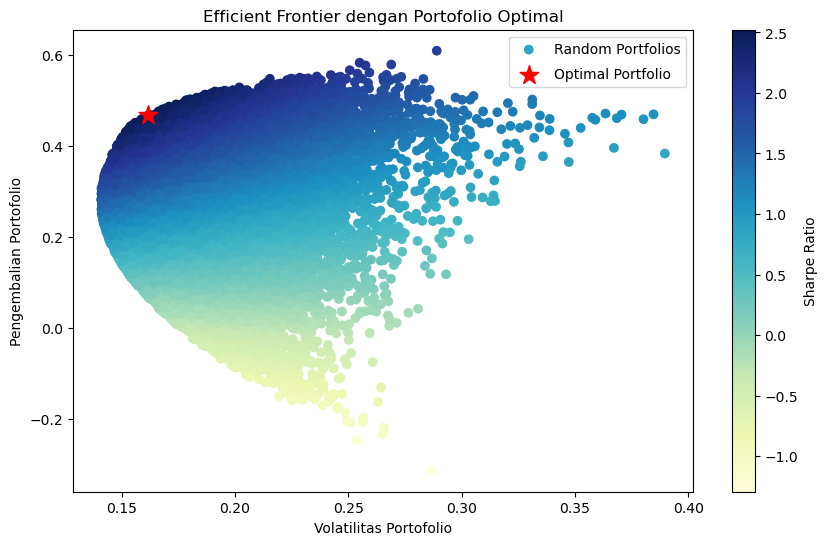

In [12]:
# Portofolio Optimal
print("Portofolio Optimal")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"Bobot untuk {ticker}: {weight:%}")
print(f"Return = {optimal_return:.6}, Volatilitas = {optimal_volatility:.6}")
print(f"Sharpe Ratio = {optimal_sharpe}")

# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(port_vols, port_returns, c=sharpe_ratios, cmap='YlGnBu', marker='o', label='Random Portfolios')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, color='r', marker='*', s=200, label='Optimal Portfolio')
plt.title('Efficient Frontier dengan Portofolio Optimal')
plt.xlabel('Volatilitas Portofolio')
plt.ylabel('Pengembalian Portofolio')
plt.legend(labelspacing=0.8)
plt.show()

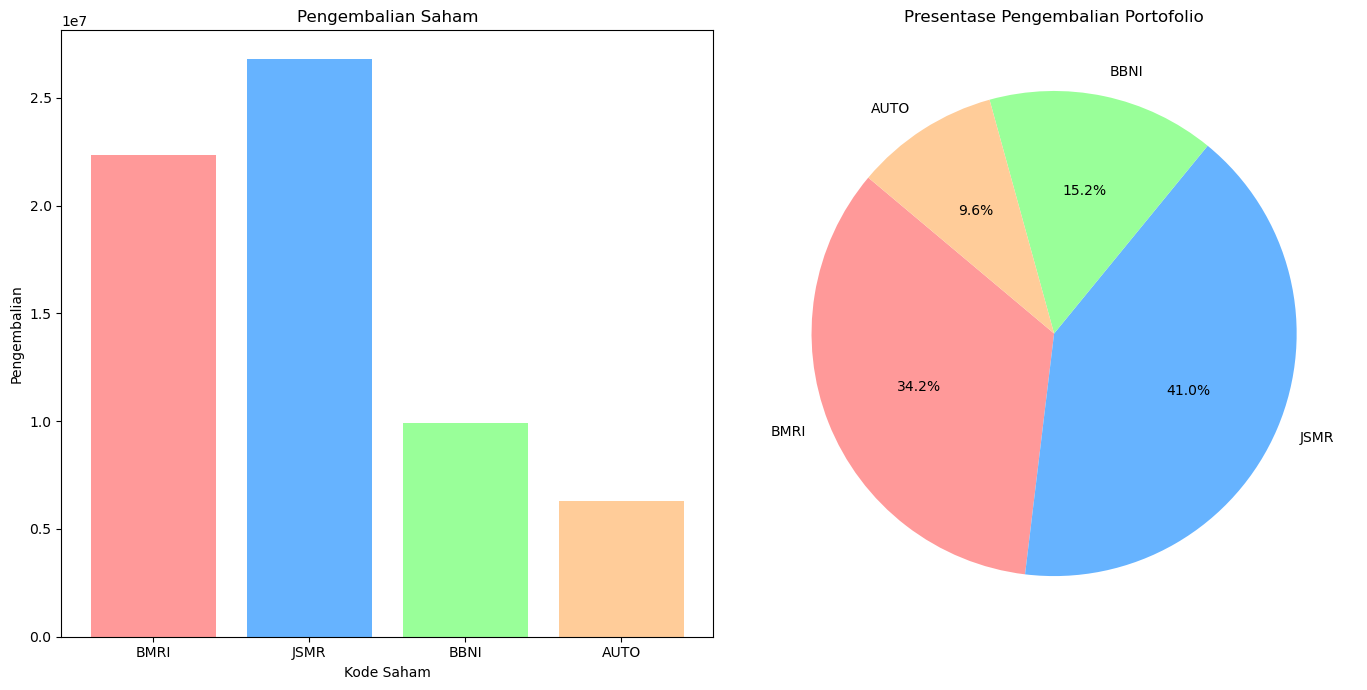

In [13]:
# Data for bar chart
companies = ['BMRI', 'JSMR', 'BBNI', 'AUTO']
values = [22372560, 26797800, 9911160, 6300000]

# Data for pie chart
portfolio_weights = [34.2, 41, 15.2, 9.6]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Bar chart
ax[0].bar(companies, values, color=colors)
ax[0].set_title('Pengembalian Saham')
ax[0].set_ylabel('Pengembalian')
ax[0].set_xlabel('Kode Saham')

# Pie chart
ax[1].pie(portfolio_weights, labels=companies, autopct='%1.1f%%', startangle=140, colors=colors)
ax[1].set_title('Presentase Pengembalian Portofolio')

# Adjust layout to fit both charts
plt.tight_layout()
plt.show()